# NEURAL NETWORK

##### All algorithms were designed by Hyungjoo Kim and Dataset was provided by UCL

In [1]:
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt

from numpy.linalg import inv
from numpy.random import randn
from sklearn import svm
from sklearn import datasets as skdataset
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
train_label = np.load('Data_IRIS&MNIST/IRIS/iris_train_labels.npy') # [2 1 1 0 2 2 2 0 1...] (96,)
train_samp = np.load('Data_IRIS&MNIST/IRIS/iris_train_samples.npy') # (96,4) sepal length, sepal width, petal length, petal width.
val_label = np.load('Data_IRIS&MNIST/IRIS/iris_val_labels.npy')
val_samp = np.load('Data_IRIS&MNIST/IRIS/iris_val_samples.npy')
# Class
# Iris Setosa for label 0
# Iris Versicolour label 1
# Iris Virginica for label 2
MNIST_train_label = np.load('Data_IRIS&MNIST/MNIST/mnist_train_labels.npy')
MNIST_train_samp = np.load('Data_IRIS&MNIST/MNIST/mnist_train_samples.npy')  # (44800, 28*28)
MNIST_val_label = np.load('Data_IRIS&MNIST/MNIST/mnist_val_labels.npy')
MNIST_val_samp = np.load('Data_IRIS&MNIST/MNIST/mnist_val_samples.npy')

**Task 1: Devise a three-layer neural network with n hidden states and sigmoid activation for classification. Exaplain how many parameters this has in one sentence.**

**Answer:** This task requires 3 layers neural network with 3 hidden states (Whh, Whx and Why) and these states are used by **4 parameters that represent hh + (input_size * h) + (output_size * h).** 

**Task 2: Provide the equation for the gradient using chain rule for the network in point a).**

In [6]:
h = 100 # hidden size
X = MNIST_train_samp   #(44800, 28*28)
y = MNIST_train_label
y = [[0, 1] if Y == 1 else (1, 0) for Y in y]   # make one hot
y = np.array(y)

Whh = randn(h, h) * 0.01    # (100, 100)
Wxh = randn(X.shape[1], h) * 0.01  # (784, 100)
Why = randn(h, y.shape[1]) * 0.01  # (100, 2)

# forward_propagation
XW = np.matmul(X, Wxh)
hidden_1 = 1 / (1 + np.exp(-XW))

hidden_1Whh = np.matmul(hidden_1, Whh)
before_h2 = hidden_1Whh + XW
hidden_2 = 1 / (1 + np.exp(-before_h2))

hidden_2Whh = np.matmul(hidden_2, Whh)
before_h3 = hidden_2Whh + XW
hidden_3 = 1 / (1 + np.exp(-before_h3))

y_preds = np.matmul(hidden_3, Why)  #(n, h) (h, 2)
loss = np.square(y_preds - y).sum()

# backward_propagation
grad_y_preds = (y_preds - y) * 2.0  # n, 2
grad_Why = np.matmul(hidden_3.T, grad_y_preds)  # (h, n) (n, 2) >> hidden_2
grad_hidden_3 = np.matmul(grad_y_preds, Why.T)  # (n, 2) (2, h) >> nh
grad_before_h3 = grad_hidden_3 * hidden_3 * (1 - hidden_3)   # (n, h)
grad_hidden_2 = np.matmul(grad_before_h3, Whh.T)  #(n, h) (h, h) >> nh
grad_Whh = np.matmul(hidden_2.T, grad_before_h3)  # (h, n) (n, h) >> (h, h)
grad_X = np.matmul(grad_before_h3, Wxh.T)  # (n, h) (h, n) >> (n, n)
grad_Wxh = np.matmul(X.T, grad_before_h3)  # (n, n) (n, h) >> (n, h)
grad_before_h2 = grad_hidden_2 * hidden_2 * (1 - hidden_2)  # (n, h)
grad_hidden_1 = np.matmul(grad_before_h2, Whh.T)  #(n, h)
grad_Whh = grad_Whh + np.matmul(hidden_1.T, grad_before_h2)
grad_Wxh = grad_Wxh + np.matmul(X.T, grad_before_h2)
grad_Wxh = grad_Wxh + np.matmul(X.T, (grad_hidden_1 * hidden_1 * (1 - hidden_1))) # in, n * n
# sigmoid(x) * (1-sigmoid(x))

**Task 3:Implement the binary classifier nnclass(examplesA, examplesB, testExamples) that is trained with
your implementation of (stochastic) GD and your gradient function using the network.**

In [7]:
class train(): 
    def __init__(self, Whh, Wxh, Why):
        self.Whh = Whh
        self.Wxh = Wxh
        self.Why = Why
        
    def forward_pass(self, X):
        self.X = X
        self.XW = np.matmul(X, self.Wxh)
        self.hidden_1 = 1 / (1 + np.exp(-self.XW))  # (n, h)
        self.hidden_1_Whh = np.matmul(self.hidden_1, self.Whh)  # (n, h)
        self.before_hidden_2 = self.hidden_1_Whh + self.XW  #(n, h)
        self.hidden_2 = 1 / (1 + np.exp(-self.before_hidden_2))  # (n, h)
        self.hidden_2_Whh = np.matmul(self.hidden_2, self.Whh)
        self.before_hidden_3 = self.hidden_2_Whh + self.XW
        self.hidden_3 = 1 / (1 + np.exp(-self.before_hidden_3))
        self.y_preds = np.matmul(self.hidden_3, self.Why)   # (n, h) (h, 2)
        
        return self.y_preds
    
    def loss_function(self, y_preds, y):
        self.y = y
        self.loss = np.square(self.y_preds - self.y).sum()
        
        return self.loss
    
    def backward_pass(self):
        self.grad_y_preds = (self.y_preds - self.y) * 2.0
        self.grad_Why = np.matmul(self.hidden_3.T, self.grad_y_preds)  # (h, n) (n, 2) >> hidden_2
        self.grad_hidden_3 = np.matmul(self.grad_y_preds, self.Why.T)  # (n, 2) (2, h) >> nh
        self.grad_before_h3 = self.grad_hidden_3 * self.hidden_3 * (1 - self.hidden_3)   # (n, h)
        self.grad_hidden_2 = np.matmul(self.grad_before_h3, self.Whh.T)  #(n, h) (h, h) >> nh
        self.grad_Whh = np.matmul(self.hidden_2.T, self.grad_before_h3)  # (h, n) (n, h) >> (h, h)
        #self.grad_X = np.matmul(self.grad_before_h3, self.Wxh.T)  # (n, h) (h, n) >> (n, n)
        self.grad_Wxh = np.matmul(self.X.T, self.grad_before_h3)  # (n, n) (n, h) >> (n, h)
        self.grad_before_h2 = self.grad_hidden_2 * self.hidden_2 * (1 - self.hidden_2)  # (n, h)
        self.grad_hidden_1 = np.matmul(self.grad_before_h2, self.Whh.T)  #(n, h)
        self.grad_Whh = self.grad_Whh + np.matmul(self.hidden_1.T, self.grad_before_h2)
        self.grad_Wxh = self.grad_Wxh + np.matmul(self.X.T, self.grad_before_h2)
        self.grad_Wxh = self.grad_Wxh + np.matmul(self.X.T, (self.grad_hidden_1 * self.hidden_1 * (1 - self.hidden_1))) # in, n * n
        
def nnclass(examplesA, examplesB, testExamples):
    # batch_size and learning parameters
    a_num = len(examplesA)
    b_num = len(examplesB)
    batch = 128
    a_batch = int(128 * (a_num / (a_num + b_num)))
    b_batch = batch - a_batch
    iterations = (a_num + b_num) // 128 + 1 if (a_num + b_num) % 128 != 0 else (a_num + b_num) // 128
    hidden = 100  # hidden layer width
    learning_rate = 0.0001
    epochs = 50
    
    # Initialising
    Whh = randn(h, h) * 0.01
    Wxh = randn(examplesA.shape[1], h) * 0.01  # 784, 100
    Why = randn(h, 1) * 0.01  # 100, 2
    model = train(Whh, Wxh, Why)
    
    for epoch in range(epochs):
        for i in range(iterations):
            if i == iterations - 1:
                A_sub = examplesA[i * a_batch :]
                B_sub = examplesB[i * b_batch :]
            else:
                A_sub = examplesA[i * a_batch : (i + 1) * a_batch]
                B_sub = examplesB[i * b_batch : (i + 1) * b_batch]
                
            X = np.vstack([A_sub, B_sub])
            y_zeros = (np.zeros(len(B_sub))[np.newaxis]).T
            y_ones = (np.ones(len(A_sub))[np.newaxis]).T
            y = np.vstack([y_ones, y_zeros])
            
            y_preds = model.forward_pass(X)
            loss = (model.loss_function(y_preds, y))
            model.backward_pass()
            
            # backward pass and optimizing
            Whh -= learning_rate * model.grad_Whh
            Wxh -= learning_rate * model.grad_Wxh
            Why -= learning_rate * model.grad_Why
        print(f"{(epoch + 1)} / {epochs}, Loss value is: ", loss)
        
    # validation set
    y_preds = model.forward_pass(testExamples)
    y_preds = (y_preds >= 0.5) * 1
    
    return y_preds

In [8]:
train_one = (MNIST_train_samp[MNIST_train_label == 1])
train_non_one = (MNIST_train_samp[MNIST_train_label != 1])
predictions_1 = nnclass(train_one, train_non_one, MNIST_val_samp)
ground_truth = MNIST_val_label
ground_truth = [1 if y == 1 else 0 for y in ground_truth]
print("Accuracy value is: ", accuracy_score(ground_truth, predictions_1))

1 / 50, Loss value is:  5.895711381737013
2 / 50, Loss value is:  5.11010494780861
3 / 50, Loss value is:  4.719286612011189
4 / 50, Loss value is:  4.210346113198342
5 / 50, Loss value is:  4.126657504275382
6 / 50, Loss value is:  3.7891906865701928
7 / 50, Loss value is:  3.5259686955431517
8 / 50, Loss value is:  3.168074993515801
9 / 50, Loss value is:  3.0199498129762317
10 / 50, Loss value is:  2.866354756260951
11 / 50, Loss value is:  2.7541943611675266
12 / 50, Loss value is:  2.697630782365632
13 / 50, Loss value is:  2.8332786801906176
14 / 50, Loss value is:  2.544982077952598
15 / 50, Loss value is:  2.543363889894092
16 / 50, Loss value is:  2.417878030799562
17 / 50, Loss value is:  2.4169433069351287
18 / 50, Loss value is:  2.4115334191271316
19 / 50, Loss value is:  2.34456983698386
20 / 50, Loss value is:  2.3237632462846944
21 / 50, Loss value is:  2.262886053422734
22 / 50, Loss value is:  2.161211281018425
23 / 50, Loss value is:  2.0244883406622627
24 / 50, Loss

**Task 4: Do an analysis how changes of n affect the accuracy with MNIST. Positive labels are assigned to digit 1 and negative samples to other digits. Write not longer than fifteen sentences. A table and / or plot is
welcome.**

In [9]:
np.random.seed(0)

class train(): 
    def __init__(self, input_dim, n):
        self.Whh = randn(h, h) * 0.01  # (100, 100)
        self.Wxh = randn(input_dim, h) * 0.01 #  (784, 100)
        self.Why = randn(h, 1) * 0.01  #(100, 2)
        self.grad_Whh = np.zeros(self.Whh.shape)
        self.grad_Wxh = np.zeros(self.Wxh.shape)
        self.n = n
        self.h = [0] * n
        self.grad_h = [0] * n
        
    def forward_pass(self, X):
        self.X = X
        self.XW = np.matmul(X, self.Wxh)
        self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
        for i in range(self.n - 1):
            self.before_hidden = np.matmul(self.h[i], self.Whh) + self.XW  # (n, h)
            self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)
        self.y_preds = np.matmul(self.h[-1], self.Why)  # (n, h) (h, 2)
        
        return self.y_preds
                           
    def loss_function(self, y_preds, y):
        self.y = y
        self.loss = np.square(self.y_preds - self.y).sum()
        
        return self.loss
    
    def backward_pass(self):
        self.grad_y_preds = (self.y_preds - self.y) * 2.0   # (n, 2)
        self.grad_Why = np.matmul(self.h[-1].T, self.grad_y_preds)  # (h, n) (n, 2) >> hidden_2
        self.grad_h[-1] = np.matmul(self.grad_y_preds, self.Why.T)  # (n, 2) (2, h) >> nh
        for i in range(self.n - 1):
            self.grad_before_h = self.grad_h[-i - 1] * self.h[-i - 1] * (1 - self.h[-i - 1])   # (n, h)
            self.grad_h[-i - 2] = np.matmul(self.grad_before_h, self.Whh.T)  #(n, h) (h, h) >> nh
            self.grad_Whh += np.matmul(self.h[-i - 2].T, self.grad_before_h)  # (h, n) (n, h) >> (h, h)
            self.grad_Wxh += np.matmul(self.X.T, self.grad_before_h)  # (n, n) (n, h) >> (n, h)
            
        self.grad_Wxh = self.grad_Wxh + np.matmul(self.X.T, (self.grad_h[0] * self.h[0] * (1 - self.h[0]))) # in, n * n
        
def nnclass(examplesA, examplesB, testExamples, n):
    # batch_size and learning parameters
    a_num = len(examplesA)
    b_num = len(examplesB)
    batch = 128
    a_batch = int(128 * (a_num / (a_num + b_num)))
    b_batch = batch - a_batch
    iterations = (a_num + b_num) // 128 + 1 if (a_num + b_num) % 128 != 0 else (a_num + b_num) // 128
    hidden = 100  # hidden layer width
    learning_rate = 0.0001
    epochs = 3
    
    # Initialising
    input_dims = examplesA.shape[1]
    n = n
    model = train(input_dims, n)
    
    for epoch in range(epochs):
        for i in range(iterations):
            if i == iterations - 1:
                A_sub = examplesA[i * a_batch :]
                B_sub = examplesB[i * b_batch :]
            else:
                A_sub = examplesA[i * a_batch : (i + 1) * a_batch]
                B_sub = examplesB[i * b_batch : (i + 1) * b_batch]
                
            X = np.vstack([A_sub, B_sub])
            y_zeros = (np.zeros(len(B_sub))[np.newaxis]).T
            y_ones = (np.ones(len(A_sub))[np.newaxis]).T
            y = np.vstack([y_ones, y_zeros])
            
            y_preds = model.forward_pass(X)
            loss = (model.loss_function(y_preds, y))
            model.backward_pass()
            
            # backward pass and optimizing
            model.Whh -= learning_rate * model.grad_Whh
            model.Wxh -= learning_rate * model.grad_Wxh
            model.Why -= learning_rate * model.grad_Why
        print(f"{(epoch + 1)} / {epochs}, Loss value is: ", loss)
        
    # validation set
    y_preds = model.forward_pass(testExamples)
    y_preds = (y_preds >= 0.5) * 1
    
    return y_preds

In [10]:
train_one = (MNIST_train_samp[MNIST_train_label == 1])
train_non_one = (MNIST_train_samp[MNIST_train_label != 1])
accuracy_list = []
n_list = [1, 2, 3, 4, 9, 22, 38, 45, 63, 76, 81, 94, 100]
for n in (n_list):
    predictions_2 = nnclass(train_one, train_non_one, MNIST_val_samp, n)
    accuracy = accuracy_score(ground_truth, predictions_2)
    print("Accuracy value is: ", accuracy, f"for n = {n}")
    accuracy_list.append(accuracy)

<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)


1 / 3, Loss value is:  5.979318658450309
2 / 3, Loss value is:  5.726019403721526
3 / 3, Loss value is:  5.832826609622479
Accuracy value is:  0.9911428571428571 for n = 1


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.998425083023923
2 / 3, Loss value is:  5.6463530383573115
3 / 3, Loss value is:  6.18876725777624
Accuracy value is:  0.9895714285714285 for n = 2


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.118331995007262
2 / 3, Loss value is:  6.661888257287453
3 / 3, Loss value is:  5.659985532208972
Accuracy value is:  0.9901428571428571 for n = 3


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.004737948532997
2 / 3, Loss value is:  6.340923286020731
3 / 3, Loss value is:  6.447536383797779
Accuracy value is:  0.991 for n = 4


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.055116025014176
2 / 3, Loss value is:  6.425108303170878
3 / 3, Loss value is:  6.227924971020729
Accuracy value is:  0.9901428571428571 for n = 9


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.321797310857083
2 / 3, Loss value is:  5.329516900257527
3 / 3, Loss value is:  5.158106995888094
Accuracy value is:  0.9898571428571429 for n = 22


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.762369260267522
2 / 3, Loss value is:  6.7410782628365675
3 / 3, Loss value is:  5.790815471566203
Accuracy value is:  0.9901428571428571 for n = 38


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.617513489883052
2 / 3, Loss value is:  5.812519016471316
3 / 3, Loss value is:  6.612671476686701
Accuracy value is:  0.9904285714285714 for n = 45


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.477638672149377
2 / 3, Loss value is:  5.125954266052716
3 / 3, Loss value is:  5.446108015289759
Accuracy value is:  0.9892857142857143 for n = 63


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.271953409191169
2 / 3, Loss value is:  6.235465447767364
3 / 3, Loss value is:  6.329997031069915
Accuracy value is:  0.9907142857142858 for n = 76


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  6.05017708841966
2 / 3, Loss value is:  6.35800003998343
3 / 3, Loss value is:  5.773969416134753
Accuracy value is:  0.9912857142857143 for n = 81


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  5.636851576269255
2 / 3, Loss value is:  7.044146817417235
3 / 3, Loss value is:  6.351620750532439
Accuracy value is:  0.9897142857142858 for n = 94


<ipython-input-9-dd70f8065fce>:17: RuntimeWarning: overflow encountered in exp
  self.h[0] = 1 / (1 + np.exp(-self.XW))  # (n, h)
<ipython-input-9-dd70f8065fce>:20: RuntimeWarning: overflow encountered in exp
  self.h[i + 1] = 1 / (1 + np.exp(-self.before_hidden))   # (n, h)


1 / 3, Loss value is:  5.82789809266329
2 / 3, Loss value is:  6.921442680978842
3 / 3, Loss value is:  6.332761710173156
Accuracy value is:  0.9908571428571429 for n = 100


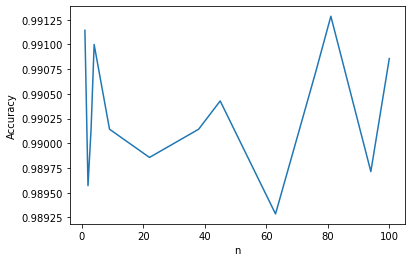

In [11]:
plt.plot(n_list, accuracy_list)
plt.xlabel("n")
plt.ylabel("Accuracy")
plt.show()

|  n   |     Accuracy     
|:----:|:----------------:|  
|  1   |0.9911428571428571|
|  2   |0.9895714285714285|
|  3   |0.9901428571428571|
|  4   |       0.991      |
|  9   |0.9901428571428571|
|  22  |0.9898571428571429|
|  38  |0.9901428571428571|
|  45  |0.9904285714285714|
|  63  |0.9892857142857143|
|  76  |0.9907142857142858|
|  81  |0.9912857142857143|
|  94  |0.9897142857142858|
|  100 |0.9908571428571429|

**Answer:** **As shown above the figure, the number of hidden states do not significantly affect the accuracy on the test.** Many layers or wide hidden size seems ideal to allow giving better results. However, these mean that can exercise and use more function for training or testing. If the neural network uses more functions, it is more complex, which results in overfitting to the data and spends lots of time. The number of data was given constant during this project and the number of data should be sufficient samples to train and test in the network to get higher accuracy if the hidden states increase. Therefore, the accuracy might depend on proper the number of hidden states (to avoid over/under-fitting) and also depend on the quality of the model, which means the quantity and size of the training sample or data.